In [23]:
import sys; sys.path
import pandas as pd
import numpy as np 
import seaborn as sns
import scipy.io as sio
import os
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold, StratifiedKFold
from sklearn import preprocessing, linear_model
from sklearn.metrics import explained_variance_score, r2_score, make_scorer
from sklearn.preprocessing import StandardScaler
from joblib import parallel_backend, Parallel, delayed

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import matplotlib
from prediction_functions import *

In [6]:

plot_figure(gcv_values_r2,'correlation_pairwiseSC_fs86',0.96)


NameError: name 'gcv_values_r2' is not defined

In [18]:
data_dir = '/home/ubuntu/enigma/'
results_dir='/home/ubuntu/enigma/results/correlation_pairwiseSC_fs86/'

df =  pd.read_csv(data_dir + 'Behaviour_Information_ALL_April7_2022.csv', header=0)
idx=np.isnan(df['NORMED_MOTOR'])

df=df[~idx]

site=df['SITE']

chronicity=df['CHRONICITY']
df_chronic=df[df['CHRONICITY']==180]
df_chronic=df_chronic.reset_index(drop=True)
ids=df_chronic['BIDS_ID']
ses=df_chronic['SES']
ids.to_csv(data_dir + '/chronic_ids.csv')

# Load SC pairwise (chronic)

# sub-r029s005 no MRI?
# sub-r052s034 no MRI?
# unpickle 
import pickle
import numpy as np
import scipy.io as sio
import os

sc= np.zeros([len(ids),3655])
nROIs=86

#chacoconn
for i in range(0,len(ids)):
    if i==293:
        print(ids[i])
        continue
    if i==519:
        print(ids[i])
        continue
    with open('/home/ubuntu/enigma/fs86/%s_ses-1_space-MNI152_desc-T1-lesion_mask_MNI_1mm_nemo_output_sdstream_chacoconn_fs86subj_nemoSC_mean.mat'% (ids[i]), 'rb') as e:
        data=sio.loadmat(e)['SC']
    
    # pairwise vectorized upper triangular
    np.fill_diagonal(data, 0)
    sc[i,:] = data[np.triu_indices(nROIs,k=1)]

sc = np.delete(sc,(519), axis=0)   
sc = np.delete(sc,(293), axis=0)   

fuglmeyer=df_chronic['NORMED_MOTOR']

fuglmeyer.pop(519)
fuglmeyer.pop(293)
        

sub-r029s005
sub-r052s034


0.477272727

In [19]:
# -------------------- MODEL OPTIMIZATION --------------------
# range of alphas
n_alphas=30
alpha_start=-2
alpha_end=2
alphas = np.logspace(alpha_start, alpha_end, n_alphas, base=10,dtype=None)
p=0

#number of features (# pricipal components or variables to retain)
feat_start=900
feat_end=1000

n_feats=feat_end-feat_start+1
feats = np.linspace(feat_start, feat_end, n_feats, dtype=int)

#set the proportion of data you want in your training set
train_size = .8

#set the number of folds you want in the inner and outer folds of the nested cross-validation
k = 5
#set x data to be the input variable you want to use
#ie fc, sc, or hc
#X=np.concatenate([sc, fc], axis=1)
X=np.array(sc)
X=pf.prepare_data(X)

#set y to be the measure you want to predict
Y = np.array(fuglmeyer)
Y=np.reshape(Y, (627,1))

featselect = 'correlation'

# set aside data for hold-out final testing: 
x, x_test, y, y_test = train_test_split(X, Y, test_size=1-train_size, shuffle=True, random_state=134)

bestalpha, bestfeats, bestr2, gcv_values_r2= gridsearch_cv(k, x, y, featselect, alphas, feats)

row=np.argmax(np.max(gcv_values_r2, axis=1))
col=np.argmax(np.max(gcv_values_r2, axis=0))
k = 5
bestalpha=alphas[row]
bestfeats=feats[col]

print('Best combination: \n alpha = ', str(alphas[row]), '\n Features = ', str(feats[col]), '\n R^2 = ', str(np.round(np.max(gcv_values_r2), 3)))

# initialize Ridge regression with alpha selected from hyperparameter search
regr = linear_model.Ridge(alpha=bestalpha, normalize=True, max_iter=1000000, random_state=p)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=1-train_size, shuffle=True, random_state=121)

if featselect=='correlation':
    x_train_featselect,x_test_featureselect,ind = feature_select_correlation(x_train,x_test, y_train, bestfeats)

# initialize Ridge regression with alpha selected from hyperparameter search
regr = linear_model.Ridge(alpha=bestalpha, normalize=True, max_iter=1000000, random_state=p)

# fit model 
y_pred = regr.fit(x_train_featselect, y_train).predict(x_test_featureselect)

expl=explained_variance_score(y_test, y_pred)

print(expl)

plt.scatter(y_test, y_pred)


TypeError: 'module' object is not callable

In [28]:
from prediction_functions4 import *
prepare_data

<function prediction_functions4.prepare_data(X)>

In [5]:
# predictions for SC-  PCA and correlation

import datetime
import pickle 

# feature selection type
f=['correlation']

for featselect in f: 
    #set the number of folds you want in the inner and outer folds of the nested cross-validation
    k = 5

    #set the proportion of data you want in your training set
    train_size = .8

    #X=np.concatenate([sc, fc], axis=1)
    X=sc
    X=prepare_data(X)
    #set y to be the measure you want to predict
    #Y = np.log(np.array(tmt))

    Y=np.array(fuglmeyer)
    Y=np.reshape(Y, (627,1))
    
    # range of alphas
    n_alphas=30
    alpha_start=-2
    alpha_end=2
    alphas = np.logspace(alpha_start, alpha_end, n_alphas, base=10, dtype=None)

    #number of features (# pricipal components or variables to retain)
    feat_start=50
    feat_end=1000
    n_feats=30
    feats = np.linspace(feat_start, feat_end, n_feats, dtype=int)

    # initialize lists to store model results for each permuation
    allR2=[]
    meanR2=[]
    features=[]
    bestalphas=[]
    importance=[]
    allexpl_var=[]
    correlations=[]
    chronic_allexpl_var=[]
    chronic_correlationr2_all=[]
    #joblib-based parallelism to increase speed,
    ytestc=[]
    ypredc=[]
    for p in range(0, 100):
        outer_cv = KFold(n_splits=k, shuffle=True, random_state=p)
        print('Permutation: ' + str(p))
        # initialize lists to store model results for eah fold
        R2=[]
        featur=[]
        best_alphas=[]
        impt=[] 
        expl_var=[]
        chronic_explvar=[]
        chronic_correlationr2=[]

        cor=[]
        for train, test in outer_cv.split(X):
            begin_time = datetime.datetime.now()
            
            
            # select model using training data
            bestalpha, bestfeats, bestr2, gcv_values = gridsearch_cv(k, X[train], Y[train], featselect, alphas, feats)

            # using optimal num. of features, select final features using entire training data.

            if featselect=='correlation':
                x_train_featselect,x_test_featureselect,ind = feature_select_correlation(X[train],X[test], Y[train], bestfeats)
                featur.append(ind)

            elif featselect=='PCA':
                x_train_featselect,x_test_featureselect,ind  = feature_select_PCA(X[train],X[test], bestfeats)
                featur.append(ind)
                
            # initialize Ridge regression with alpha selected from hyperparameter search
            regr = linear_model.Ridge(alpha=bestalpha, normalize=True, max_iter=1000000, random_state=p)

            # fit model 
            y_pred = regr.fit(x_train_featselect, Y[train]).predict(x_test_featureselect)

            # store results for each fold k
            impt.append(regr.coef_)
            expl_var.append(explained_variance_score(Y[test], y_pred))

            best_alphas.append(bestalpha)
            print('time to run loop: ' + str(datetime.datetime.now() - begin_time)) 
            print("Explained var: " + str(explained_variance_score(Y[test], y_pred)))
            print("correlation: " + str(np_pearson_cor(Y[test], y_pred)))
            
    
            cor.append(np_pearson_cor(Y[test], y_pred))
            Xtest=x_test_featureselect
            Xtrain=X[train]
            Ytest=Y[test]

        # store results for each permutation p

        allexpl_var.append(expl_var)
        bestalphas.append(best_alphas)
        importance.append(impt)
    
        print("---- Permutation avg. explained variance: " + str(np.mean(expl_var)) + "----")
        np.savetxt(results_dir + featselect + 'p' + str(p) + '_SC_all_explvar.txt', expl_var, delimiter=',')

        output = open(results_dir + featselect + 'p' + str(p) + '_SC_features.pkl', 'wb')
        pickle.dump(featur, output)
        output.close()
        
        output = open(results_dir + featselect + 'p' + str(p) + '_SC_correlations.pkl', 'wb')
        pickle.dump(correlations, output)
        output.close()

        output = open(results_dir + featselect + 'p' + str(p) + '_SC_bestalphas.pkl', 'wb')
        pickle.dump(best_alphas, output)
        output.close()
     
        output = open(results_dir + featselect + 'p' + str(p) + '_SC_varimpt.pkl', 'wb')
        pickle.dump(impt, output)
        output.close()   
        

Final size of X: (627, 3192)
Permutation: 0
5-fold cross-validation results in 400.8 subjects in the training set, and 100.2 subjects in the validation set
time to run loop: 0:00:18.410629
Explained var: 0.14226510923040891
correlation: [[0.39182301]]
5-fold cross-validation results in 400.8 subjects in the training set, and 100.2 subjects in the validation set
time to run loop: 0:00:16.530870
Explained var: 0.20892762554026045
correlation: [[0.47833186]]
5-fold cross-validation results in 401.6 subjects in the training set, and 100.4 subjects in the validation set
time to run loop: 0:00:16.676114
Explained var: 0.0609933875322789
correlation: [[0.30064474]]
5-fold cross-validation results in 401.6 subjects in the training set, and 100.4 subjects in the validation set
time to run loop: 0:00:16.442554
Explained var: 0.21354647689711426
correlation: [[0.46389969]]
5-fold cross-validation results in 401.6 subjects in the training set, and 100.4 subjects in the validation set
time to run l

time to run loop: 0:00:16.293622
Explained var: 0.17842015595426408
correlation: [[0.4235893]]
5-fold cross-validation results in 401.6 subjects in the training set, and 100.4 subjects in the validation set
time to run loop: 0:00:16.494464
Explained var: 0.15242378969543147
correlation: [[0.39198734]]
5-fold cross-validation results in 401.6 subjects in the training set, and 100.4 subjects in the validation set
time to run loop: 0:00:16.430831
Explained var: 0.11638588884005763
correlation: [[0.36371112]]
5-fold cross-validation results in 401.6 subjects in the training set, and 100.4 subjects in the validation set
time to run loop: 0:00:16.556428
Explained var: 0.2525322014132402
correlation: [[0.51706848]]
---- Permutation avg. explained variance: 0.1632127890153419----
Permutation: 8
5-fold cross-validation results in 400.8 subjects in the training set, and 100.2 subjects in the validation set
time to run loop: 0:00:16.530755
Explained var: 0.16199749501702987
correlation: [[0.40261

time to run loop: 0:00:16.490926
Explained var: 0.16878503525914967
correlation: [[0.41131822]]
5-fold cross-validation results in 401.6 subjects in the training set, and 100.4 subjects in the validation set
time to run loop: 0:00:16.533682
Explained var: 0.16461578249612485
correlation: [[0.40888803]]
---- Permutation avg. explained variance: 0.15940040814191198----
Permutation: 15
5-fold cross-validation results in 400.8 subjects in the training set, and 100.2 subjects in the validation set
time to run loop: 0:00:16.522076
Explained var: 0.2515809287561742
correlation: [[0.54261796]]
5-fold cross-validation results in 400.8 subjects in the training set, and 100.2 subjects in the validation set
time to run loop: 0:00:16.542042
Explained var: 0.07736382377278395
correlation: [[0.30563858]]
5-fold cross-validation results in 401.6 subjects in the training set, and 100.4 subjects in the validation set
time to run loop: 0:00:16.498379
Explained var: 0.07501975542978112
correlation: [[0.31

time to run loop: 0:00:16.499267
Explained var: 0.140566788381977
correlation: [[0.3763363]]
5-fold cross-validation results in 400.8 subjects in the training set, and 100.2 subjects in the validation set
time to run loop: 0:00:16.489557
Explained var: 0.19133877674585242
correlation: [[0.43938995]]
5-fold cross-validation results in 401.6 subjects in the training set, and 100.4 subjects in the validation set
time to run loop: 0:00:16.579499
Explained var: 0.14453556312970717
correlation: [[0.3857832]]
5-fold cross-validation results in 401.6 subjects in the training set, and 100.4 subjects in the validation set
time to run loop: 0:00:16.624146
Explained var: 0.1880014009508021
correlation: [[0.43761766]]
5-fold cross-validation results in 401.6 subjects in the training set, and 100.4 subjects in the validation set
time to run loop: 0:00:16.556492
Explained var: 0.16273854835725876
correlation: [[0.40344302]]
---- Permutation avg. explained variance: 0.1654362155131195----
Permutation:

time to run loop: 0:00:16.599547
Explained var: 0.22065840005822868
correlation: [[0.47736446]]
5-fold cross-validation results in 401.6 subjects in the training set, and 100.4 subjects in the validation set
time to run loop: 0:00:16.686053
Explained var: 0.1356350630751565
correlation: [[0.37139396]]
5-fold cross-validation results in 401.6 subjects in the training set, and 100.4 subjects in the validation set
time to run loop: 0:00:16.623977
Explained var: 0.16758442477209634
correlation: [[0.41464828]]
---- Permutation avg. explained variance: 0.1736024751604628----
Permutation: 30
5-fold cross-validation results in 400.8 subjects in the training set, and 100.2 subjects in the validation set
time to run loop: 0:00:16.736535
Explained var: 0.16330476402960248
correlation: [[0.409439]]
5-fold cross-validation results in 400.8 subjects in the training set, and 100.2 subjects in the validation set
time to run loop: 0:00:16.488598
Explained var: 0.1344340025660945
correlation: [[0.379411

time to run loop: 0:00:16.579756
Explained var: 0.14146678530868229
correlation: [[0.38346925]]
---- Permutation avg. explained variance: 0.15715380747379867----
Permutation: 37
5-fold cross-validation results in 400.8 subjects in the training set, and 100.2 subjects in the validation set
time to run loop: 0:00:16.509810
Explained var: 0.12919017334024807
correlation: [[0.3660163]]
5-fold cross-validation results in 400.8 subjects in the training set, and 100.2 subjects in the validation set
time to run loop: 0:00:16.761294
Explained var: 0.11479450636331456
correlation: [[0.35912176]]
5-fold cross-validation results in 401.6 subjects in the training set, and 100.4 subjects in the validation set
time to run loop: 0:00:16.325428
Explained var: 0.1773314841525001
correlation: [[0.42121777]]
5-fold cross-validation results in 401.6 subjects in the training set, and 100.4 subjects in the validation set
time to run loop: 0:00:16.735829
Explained var: 0.09567148278192883
correlation: [[0.321

time to run loop: 0:00:16.796743
Explained var: 0.09050673947734267
correlation: [[0.31153952]]
5-fold cross-validation results in 401.6 subjects in the training set, and 100.4 subjects in the validation set
time to run loop: 0:00:16.256674
Explained var: 0.08627192095126324
correlation: [[0.32977403]]
5-fold cross-validation results in 401.6 subjects in the training set, and 100.4 subjects in the validation set
time to run loop: 0:00:16.614255
Explained var: 0.1304579662152886
correlation: [[0.37206771]]
5-fold cross-validation results in 401.6 subjects in the training set, and 100.4 subjects in the validation set
time to run loop: 0:00:16.532881
Explained var: 0.1829234721461539
correlation: [[0.42790894]]
---- Permutation avg. explained variance: 0.16045818173344226----
Permutation: 45
5-fold cross-validation results in 400.8 subjects in the training set, and 100.2 subjects in the validation set
time to run loop: 0:00:16.606730
Explained var: 0.265434504655642
correlation: [[0.52234

time to run loop: 0:00:16.628056
Explained var: 0.18028475980925274
correlation: [[0.42634396]]
5-fold cross-validation results in 401.6 subjects in the training set, and 100.4 subjects in the validation set
time to run loop: 0:00:16.677138
Explained var: 0.278906131611973
correlation: [[0.53391769]]
---- Permutation avg. explained variance: 0.17564554043810196----
Permutation: 52
5-fold cross-validation results in 400.8 subjects in the training set, and 100.2 subjects in the validation set
time to run loop: 0:00:16.392435
Explained var: 0.1637802469318591
correlation: [[0.40734435]]
5-fold cross-validation results in 400.8 subjects in the training set, and 100.2 subjects in the validation set
time to run loop: 0:00:16.604832
Explained var: 0.21471526438817357
correlation: [[0.46337452]]
5-fold cross-validation results in 401.6 subjects in the training set, and 100.4 subjects in the validation set
time to run loop: 0:00:16.607551
Explained var: 0.11996407899106609
correlation: [[0.3474

time to run loop: 0:00:16.904165
Explained var: 0.11017994304715062
correlation: [[0.34661623]]
5-fold cross-validation results in 400.8 subjects in the training set, and 100.2 subjects in the validation set
time to run loop: 0:00:16.527535
Explained var: 0.14909771506960978
correlation: [[0.38725891]]
5-fold cross-validation results in 401.6 subjects in the training set, and 100.4 subjects in the validation set
time to run loop: 0:00:16.730709
Explained var: 0.26485962379823
correlation: [[0.51759193]]
5-fold cross-validation results in 401.6 subjects in the training set, and 100.4 subjects in the validation set
time to run loop: 0:00:16.448048
Explained var: 0.1802683884388414
correlation: [[0.42515922]]
5-fold cross-validation results in 401.6 subjects in the training set, and 100.4 subjects in the validation set
time to run loop: 0:00:16.620363
Explained var: 0.1488495012830343
correlation: [[0.3879457]]
---- Permutation avg. explained variance: 0.17065103432737322----
Permutation:

time to run loop: 0:00:16.681457
Explained var: 0.05215464556421745
correlation: [[0.2990905]]
5-fold cross-validation results in 401.6 subjects in the training set, and 100.4 subjects in the validation set
time to run loop: 0:00:16.640985
Explained var: 0.1797243014259412
correlation: [[0.42397989]]
5-fold cross-validation results in 401.6 subjects in the training set, and 100.4 subjects in the validation set
time to run loop: 0:00:16.650440
Explained var: 0.18830994250915578
correlation: [[0.43407939]]
---- Permutation avg. explained variance: 0.15734946735685568----
Permutation: 67
5-fold cross-validation results in 400.8 subjects in the training set, and 100.2 subjects in the validation set
time to run loop: 0:00:16.702525
Explained var: 0.19668141754799384
correlation: [[0.44449133]]
5-fold cross-validation results in 400.8 subjects in the training set, and 100.2 subjects in the validation set
time to run loop: 0:00:16.346787
Explained var: 0.05246616451805253
correlation: [[0.289

time to run loop: 0:00:17.072076
Explained var: 0.028872559677595278
correlation: [[0.27975074]]
---- Permutation avg. explained variance: 0.15256330051975028----
Permutation: 74
5-fold cross-validation results in 400.8 subjects in the training set, and 100.2 subjects in the validation set
time to run loop: 0:00:17.193760
Explained var: 0.21672913619241085
correlation: [[0.47405941]]
5-fold cross-validation results in 400.8 subjects in the training set, and 100.2 subjects in the validation set
time to run loop: 0:00:16.888219
Explained var: 0.08644889755059293
correlation: [[0.32135375]]
5-fold cross-validation results in 401.6 subjects in the training set, and 100.4 subjects in the validation set
time to run loop: 0:00:16.807961
Explained var: 0.22504549976891464
correlation: [[0.47605223]]
5-fold cross-validation results in 401.6 subjects in the training set, and 100.4 subjects in the validation set
time to run loop: 0:00:16.608284
Explained var: 0.170931077292248
correlation: [[0.41

time to run loop: 0:00:16.782270
Explained var: 0.026433122557264377
correlation: [[0.24971623]]
5-fold cross-validation results in 401.6 subjects in the training set, and 100.4 subjects in the validation set
time to run loop: 0:00:16.696707
Explained var: 0.14316525380048706
correlation: [[0.38219847]]
5-fold cross-validation results in 401.6 subjects in the training set, and 100.4 subjects in the validation set
time to run loop: 0:00:16.687737
Explained var: 0.23172215281583464
correlation: [[0.48148907]]
5-fold cross-validation results in 401.6 subjects in the training set, and 100.4 subjects in the validation set
time to run loop: 0:00:16.779651
Explained var: 0.2504788492230078
correlation: [[0.52375909]]
---- Permutation avg. explained variance: 0.16690848631961946----
Permutation: 82
5-fold cross-validation results in 400.8 subjects in the training set, and 100.2 subjects in the validation set
time to run loop: 0:00:16.554766
Explained var: 0.16906571712098784
correlation: [[0.4

time to run loop: 0:00:16.634507
Explained var: 0.2278713379080014
correlation: [[0.48427944]]
5-fold cross-validation results in 401.6 subjects in the training set, and 100.4 subjects in the validation set
time to run loop: 0:00:16.694442
Explained var: 0.04124271675377178
correlation: [[0.27953357]]
---- Permutation avg. explained variance: 0.16609710678385442----
Permutation: 89
5-fold cross-validation results in 400.8 subjects in the training set, and 100.2 subjects in the validation set
time to run loop: 0:00:16.618225
Explained var: 0.07311760201280204
correlation: [[0.29475528]]
5-fold cross-validation results in 400.8 subjects in the training set, and 100.2 subjects in the validation set
time to run loop: 0:00:16.636961
Explained var: 0.21570571502222535
correlation: [[0.46563798]]
5-fold cross-validation results in 401.6 subjects in the training set, and 100.4 subjects in the validation set
time to run loop: 0:00:16.690786
Explained var: 0.27997643075413503
correlation: [[0.53

time to run loop: 0:00:16.705938
Explained var: 0.25848072660573784
correlation: [[0.5262979]]
5-fold cross-validation results in 400.8 subjects in the training set, and 100.2 subjects in the validation set
time to run loop: 0:00:16.522430
Explained var: 0.14632551696009377
correlation: [[0.3933908]]
5-fold cross-validation results in 401.6 subjects in the training set, and 100.4 subjects in the validation set
time to run loop: 0:00:16.653756
Explained var: 0.17115553312068355
correlation: [[0.41652088]]
5-fold cross-validation results in 401.6 subjects in the training set, and 100.4 subjects in the validation set
time to run loop: 0:00:16.708182
Explained var: 0.13266044373147634
correlation: [[0.36587367]]
5-fold cross-validation results in 401.6 subjects in the training set, and 100.4 subjects in the validation set
time to run loop: 0:00:16.565384
Explained var: 0.10013973946945809
correlation: [[0.33604163]]
---- Permutation avg. explained variance: 0.16175239197748992----
Permutat

In [29]:
# Haufe transformation of feature weights
k=5
Y = np.array(fuglmeyer)

# load activation weights
with open(results_dir + 'correlation' + 'p99_SC_varimpt.pkl', 'rb') as f:
    activ = pickle.load(f)
    
    
perm=0
fullactivations=[] 
#iterate through permutations
for p in range(0,100):
    # load activation weights
    with open(results_dir + 'correlation' + 'p' + str(p) + '_SC_varimpt.pkl', 'rb') as f:
        activ = pickle.load(f)
        
    k=5
    outer_cv = KFold(n_splits=k, shuffle=True, random_state=p)
    
    # Load features selected from permutation
    with open(results_dir + 'correlation' + 'p' + str(p) + '_SC_features.pkl', 'rb') as f:
        feats = pickle.load(f)
    
    c=0   
    activations=[]
    X=sc
    X=prepare_data(X)
    fullactivation=[]
    activationweight=[]
    for train, test in outer_cv.split(X,Y):
        x_train=X[train]
        X=x_train
        X_sub=X[:,feats[c][:]]
        
        print(X_sub.shape)
        
        X_sub=np.reshape(X_sub, [len(train),feats[c].shape[0]])
        cov_x=np.cov(np.transpose(X_sub))
        print('covx;')
        print(cov_x.shape)
        print(feats[c].shape[0])
        
        if feats[c].shape[0]==1:
            cov_x=np.reshape(cov_x, [1,1])
        
        cov_y=np.cov(np.transpose(Y[train]))
        
        activationweight=activ[c]
        
        
        activationweight=activationweight[0]# remove binary chronicity variable
        
        weight=np.transpose(activationweight)

        activation=np.matmul(cov_x,weight)*(1/cov_y)
        activations.append(activation)
        #print(activation.shape)

        # get activation weights back to matrix form 86x86
        # get indices of weights not selected as features; set weight to 0    
        idx=np.ones(shape=(3192,1), dtype='bool')
        idx[feats[c]]=False # set SC weights that are features to be 1
        idx=idx.flatten()
        zeroidx=np.arange(0, 3192, dtype='int')
        zeroidx=zeroidx[idx]
        
        # fill spots with 0's (up to 3192)
        k=0
        activation_full = activation
        while k < zeroidx.shape[0]:
            activation_full=np.insert(activation_full, zeroidx[k],0)
            k=k+1
        
        #print("Full 3192: " + str(np.sum(activation_full>0)))
        # fill spots with 0's (up to 3655)
        X=sc
        zeros=sc==0
        zeros=np.sum(zeros,0) # number of zeros across subjects
        zeros=zeros==X.shape[0] # find columns with zeros for all 101 subjects
        X=X[:,~zeros]
        
        zeroidx=np.arange(0, 3655)
        zeroidx=zeroidx[zeros]

        # fill spots with 0's
        k=0
        a = activation_full
        while k < zeroidx.shape[0]:
            a=np.insert(a, zeroidx[k],0)
            k=k+1
        
        #print("Full 3655: " + str(np.sum(a>0)))
        fullactivation.append(a)
        c=c+1
         
    fullactivations.append(fullactivation)

Final size of X: (627, 3192)
(501, 986, 1)
covx;
(986, 986)
986
(501, 900, 1)
covx;
(900, 900)
900
(502, 935, 1)
covx;
(935, 935)
935
(502, 938, 1)
covx;
(938, 938)
938
(502, 903, 1)
covx;
(903, 903)
903
Final size of X: (627, 3192)
(501, 964, 1)
covx;
(964, 964)
964
(501, 982, 1)
covx;
(982, 982)
982
(502, 999, 1)
covx;
(999, 999)
999
(502, 997, 1)
covx;
(997, 997)
997
(502, 930, 1)
covx;
(930, 930)
930
Final size of X: (627, 3192)
(501, 900, 1)
covx;
(900, 900)
900
(501, 968, 1)
covx;
(968, 968)
968
(502, 953, 1)
covx;
(953, 953)
953
(502, 945, 1)
covx;
(945, 945)
945
(502, 926, 1)
covx;
(926, 926)
926
Final size of X: (627, 3192)
(501, 974, 1)
covx;
(974, 974)
974
(501, 998, 1)
covx;
(998, 998)
998
(502, 997, 1)
covx;
(997, 997)
997
(502, 986, 1)
covx;
(986, 986)
986
(502, 902, 1)
covx;
(902, 902)
902
Final size of X: (627, 3192)
(501, 1000, 1)
covx;
(1000, 1000)
1000
(501, 932, 1)
covx;
(932, 932)
932
(502, 953, 1)
covx;
(953, 953)
953
(502, 987, 1)
covx;
(987, 987)
987
(502, 955, 

(502, 900, 1)
covx;
(900, 900)
900
(502, 906, 1)
covx;
(906, 906)
906
Final size of X: (627, 3192)
(501, 989, 1)
covx;
(989, 989)
989
(501, 905, 1)
covx;
(905, 905)
905
(502, 901, 1)
covx;
(901, 901)
901
(502, 900, 1)
covx;
(900, 900)
900
(502, 942, 1)
covx;
(942, 942)
942
Final size of X: (627, 3192)
(501, 900, 1)
covx;
(900, 900)
900
(501, 900, 1)
covx;
(900, 900)
900
(502, 917, 1)
covx;
(917, 917)
917
(502, 969, 1)
covx;
(969, 969)
969
(502, 924, 1)
covx;
(924, 924)
924
Final size of X: (627, 3192)
(501, 908, 1)
covx;
(908, 908)
908
(501, 953, 1)
covx;
(953, 953)
953
(502, 929, 1)
covx;
(929, 929)
929
(502, 909, 1)
covx;
(909, 909)
909
(502, 900, 1)
covx;
(900, 900)
900
Final size of X: (627, 3192)
(501, 912, 1)
covx;
(912, 912)
912
(501, 960, 1)
covx;
(960, 960)
960
(502, 1000, 1)
covx;
(1000, 1000)
1000
(502, 910, 1)
covx;
(910, 910)
910
(502, 933, 1)
covx;
(933, 933)
933
Final size of X: (627, 3192)
(501, 971, 1)
covx;
(971, 971)
971
(501, 989, 1)
covx;
(989, 989)
989
(502, 966, 

covx;
(997, 997)
997
(502, 900, 1)
covx;
(900, 900)
900
Final size of X: (627, 3192)
(501, 900, 1)
covx;
(900, 900)
900
(501, 962, 1)
covx;
(962, 962)
962
(502, 958, 1)
covx;
(958, 958)
958
(502, 987, 1)
covx;
(987, 987)
987
(502, 927, 1)
covx;
(927, 927)
927
Final size of X: (627, 3192)
(501, 900, 1)
covx;
(900, 900)
900
(501, 922, 1)
covx;
(922, 922)
922
(502, 991, 1)
covx;
(991, 991)
991
(502, 997, 1)
covx;
(997, 997)
997
(502, 906, 1)
covx;
(906, 906)
906
Final size of X: (627, 3192)
(501, 997, 1)
covx;
(997, 997)
997
(501, 952, 1)
covx;
(952, 952)
952
(502, 939, 1)
covx;
(939, 939)
939
(502, 944, 1)
covx;
(944, 944)
944
(502, 900, 1)
covx;
(900, 900)
900
Final size of X: (627, 3192)
(501, 909, 1)
covx;
(909, 909)
909
(501, 925, 1)
covx;
(925, 925)
925
(502, 1000, 1)
covx;
(1000, 1000)
1000
(502, 959, 1)
covx;
(959, 959)
959
(502, 907, 1)
covx;
(907, 907)
907
Final size of X: (627, 3192)
(501, 902, 1)
covx;
(902, 902)
902
(501, 959, 1)
covx;
(959, 959)
959
(502, 961, 1)
covx;
(961,

In [30]:
countweights=np.zeros(shape=(3655, ), dtype='int')

for p in range(0,100):
    act=fullactivations[p] # features 
    for x in range(0,5):
        #print(act[x].shape)
        countweights=countweights+act[x]

Text(0.5, 1.0, 'Number of times each SC edge was used in outer loop of cross-validation (max = 500)')

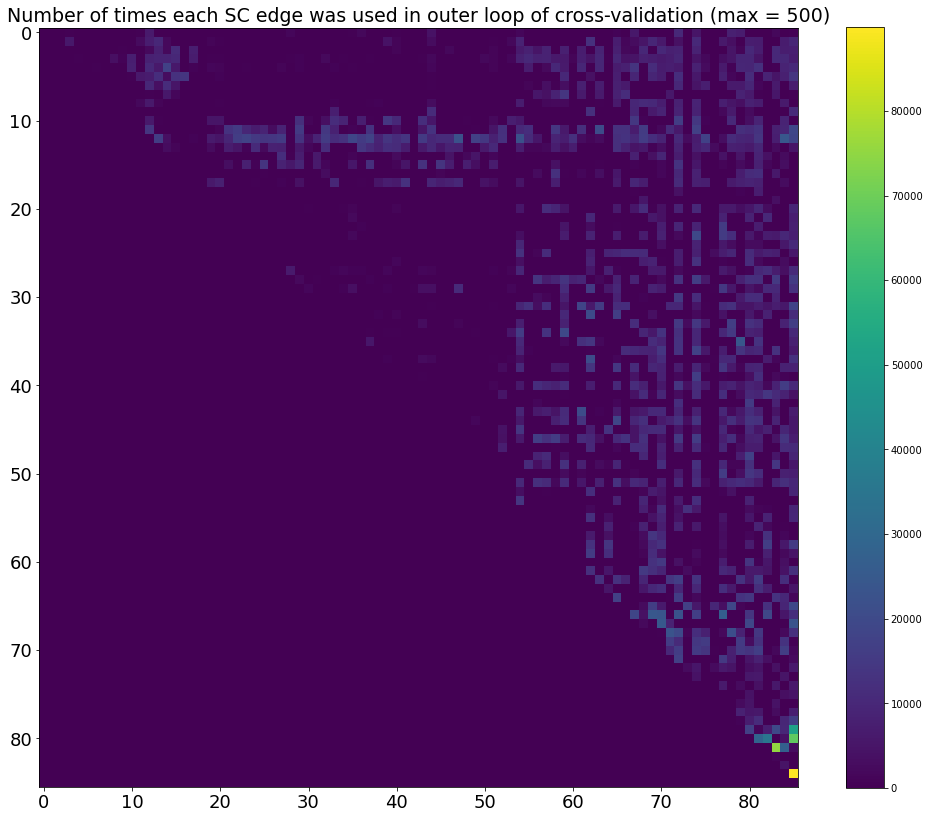

In [31]:
# convert vectorized Triu to matrix
highweights = countweights

plt.figure(figsize=(17,14))

fs86_counts = np.zeros((86, 86))
inds = np.triu_indices(86, k=1)
fs86_counts[inds] = highweights

plt.imshow(fs86_counts)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.colorbar()
plt.title('Number of times each SC edge was used in outer loop of cross-validation (max = 500)', fontsize = 19)

<Figure size 1224x1008 with 0 Axes>

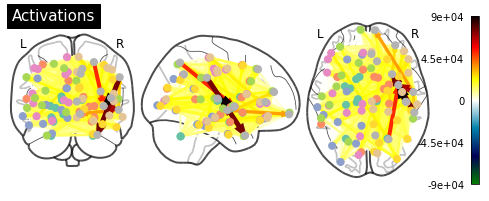

In [36]:
from nilearn import datasets
from nilearn import plotting

plt.figure(figsize=(17,14))

coordinates = plotting.find_parcellation_cut_coords('fs86_allsubj_mode2mm.nii.gz')
plotting.plot_connectome(fs86_counts, coordinates,
                         title='Activations',edge_cmap='ocean_hot',colorbar=True)

np.savetxt(results_dir +'fs86_activ_weights.txt', fs86_counts, delimiter=',')
